<a href="https://colab.research.google.com/github/KarolChlasta/PJAIT-AdvancedML/blob/master/ZTM05_DeepEyes-Scanpaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple DeepEyes II

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
import torchvision.models as models
#resnet18 = models.resnet18(pretrained=True)
#alexnet = models.alexnet(pretrained=True)
#squeezenet = models.squeezenet1_0(pretrained=True)
#vgg16 = models.vgg16(pretrained=True)
#densenet = models.densenet161(pretrained=True)
#inception = models.inception_v3(pretrained=True)
#googlenet = models.googlenet(pretrained=True)
#shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
#mobilenet = models.mobilenet_v2(pretrained=True)
#resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
#wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
#mnasnet = models.mnasnet1_0(pretrained=True)

In [0]:
bs = 2

architecture = models.resnet18 # ResNet 18

## Looking at the data

We are going to use the SWPS Dataset which features 3 mental states in 60 people. Our model will need to learn to differentiate between 3 distinct cathegories (anxious/depressive/control).

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
!mkdir data
!cp /content/drive/My\ Drive/DeepEyes/images-scanpaths-clean-448x448.tar.gz /content/data/
!tar -xvf /content/data/images-scanpaths-clean-448x448.tar.gz -C data


#!mkdir data
#!cp /content/drive/My\ Drive/DeepEyes/images-fixations-augmented.tar.gz /content/data/
#!tar -xvf /content/data/images-fixations-augmented.tar.gz -C data

mkdir: cannot create directory ‘data’: File exists
images-scanpaths-clean-448x448/
images-scanpaths-clean-448x448/anxious_K705.png
images-scanpaths-clean-448x448/anxious_92168.png
images-scanpaths-clean-448x448/anxious_K903.png
images-scanpaths-clean-448x448/depressive_MD240.png
images-scanpaths-clean-448x448/depressive_WD231.png
images-scanpaths-clean-448x448/anxious_92179.png
images-scanpaths-clean-448x448/control_92270.png
images-scanpaths-clean-448x448/anxious_K912.png
images-scanpaths-clean-448x448/depressive_WD220.png
images-scanpaths-clean-448x448/control_K906.png
images-scanpaths-clean-448x448/anxious_91130.png
images-scanpaths-clean-448x448/control_91117.png
images-scanpaths-clean-448x448/control_91133.png
images-scanpaths-clean-448x448/depressive_WD234.png
images-scanpaths-clean-448x448/anxious_91234.png
images-scanpaths-clean-448x448/depressive_WD229.png
images-scanpaths-clean-448x448/depressive_MD233.png
images-scanpaths-clean-448x448/control_WD203.png
images-scanpaths-clea

In [0]:
path_img = '/content/data/images-scanpaths-clean-448x448/'
#path_img = '/content/data/images-fixations-augmented/'

In [0]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

## Data augmentation

In [0]:
src = ImageList.from_folder(path_img).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'/([^/]+)_\w+.png$')       
           .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

In [0]:
data = get_data(1024, bs, 'zeros')

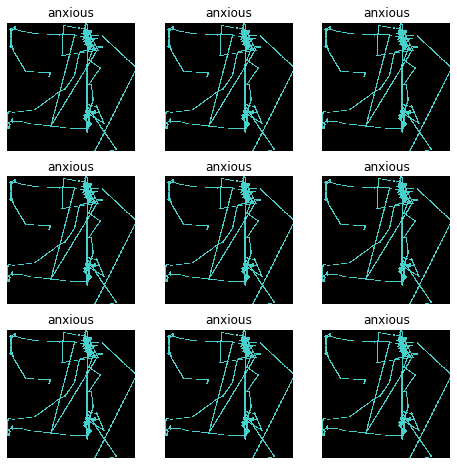

In [110]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(448,bs)

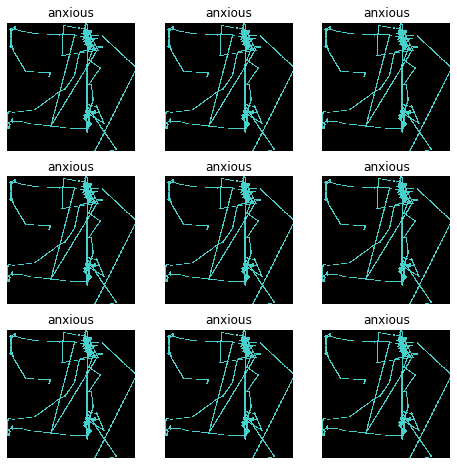

In [112]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [0]:
gc.collect()
learn = cnn_learner(data, architecture, metrics=error_rate, bn_final=True, pretrained=True)

In [114]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.75E-07


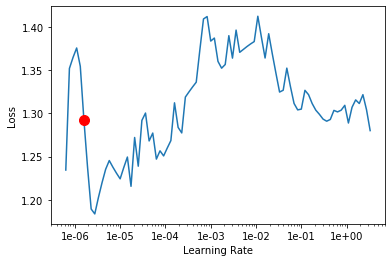

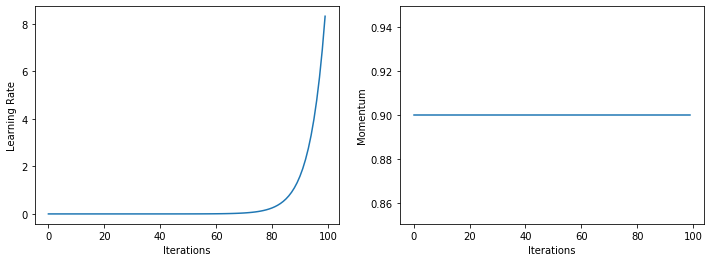

In [115]:
learn.recorder.plot(suggestion=True)
learn.recorder.plot_lr(show_moms=True)

In [116]:
learn.fit_one_cycle(4, 1e-01, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.526106,1.145837,0.636364,00:00
1,1.431077,1.097581,0.636364,00:00
2,1.270764,1.132736,0.636364,00:00
3,1.200503,1.359493,0.636364,00:00


Min numerical gradient: 8.04E-03
Min loss divided by 10: 2.06E-03


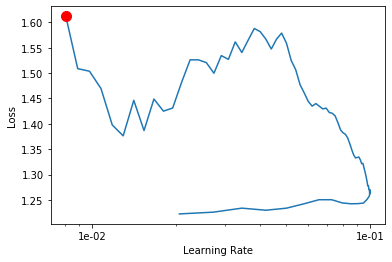

In [117]:
learn.recorder.plot(suggestion=True)

In [118]:
learn.unfreeze()
learn.fit_one_cycle(5, learn.recorder.min_grad_lr, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.100971,1.473215,0.727273,00:01
1,1.073166,6.069753,0.727273,00:01
2,1.081471,9.639807,0.727273,00:01
3,1.067034,27.017994,0.727273,00:01
4,1.085509,1.237182,0.545455,00:01


In [0]:
data = get_data(352,bs)
learn.data = data

In [0]:
learn.save('352')

## Results

In [0]:
def evaluate_model_from_interp(interp, data):
    print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
    print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
    print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)
    
    print('')
    print(f'Pred -> GroundTruth = PredLabel -> GroundTruthLabel')
    
    ok_pred = 0
    
    for idx, raw_p in enumerate(interp.preds):
        pred = np.argmax(raw_p)
        if idx < 10:
           print(f'{pred} -> {interp.y_true[idx]} = {data.classes[pred]} -> {data.valid_ds.y[idx]}')
        if pred == interp.y_true[idx]:
           ok_pred += 1
    
    acc = ok_pred / len(interp.y_true)
    print(f'Overall accuracy of the model: {acc:0.5f}')

In [122]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

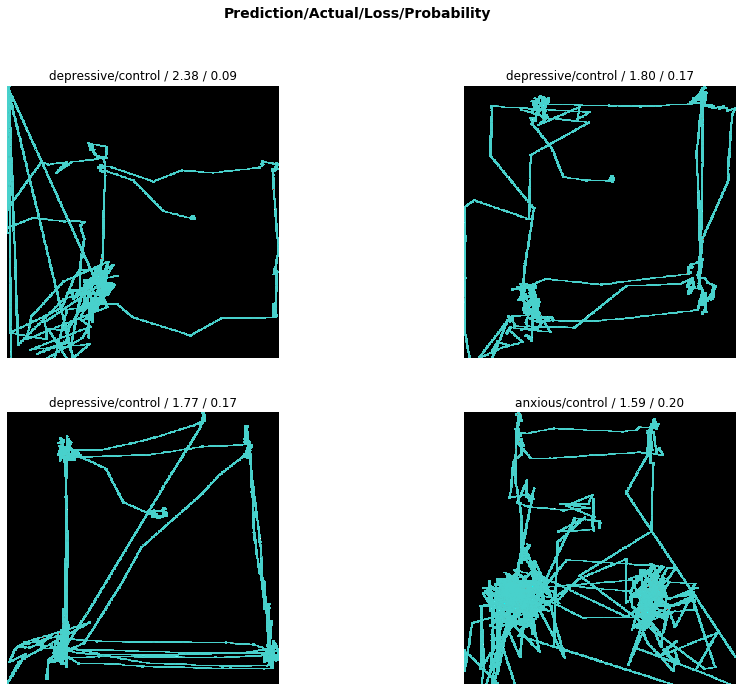

In [123]:
interp.plot_top_losses(4, figsize=(15,11))

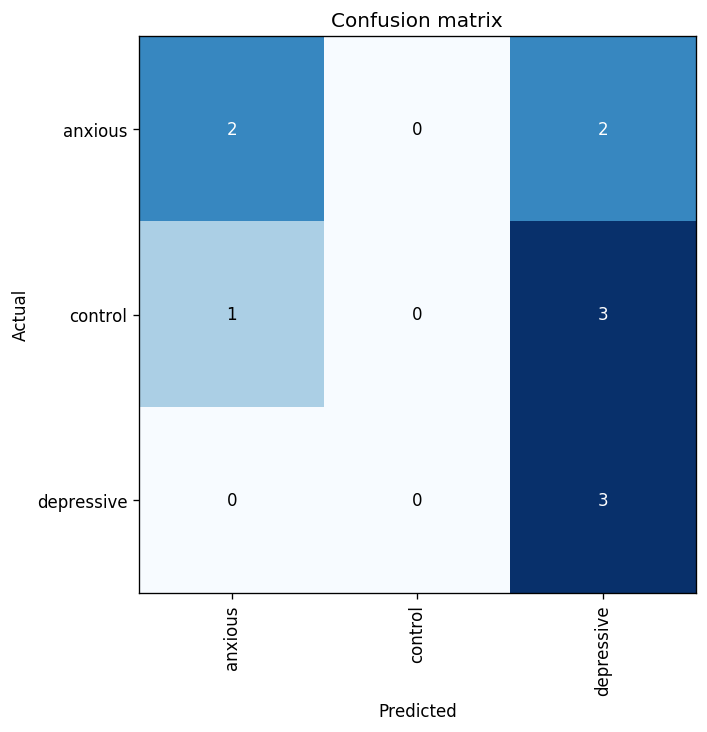

In [124]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=120)

In [125]:
interp.most_confused(min_val=2)

[('control', 'depressive', 3), ('anxious', 'depressive', 2)]

In [126]:
evaluate_model_from_interp(interp, data)

Interp has 11 ground truth labels: tensor([1, 2, 2, 1, 0, 0, 2, 0, 1, 1, 0])
Interp yielded 11 raw predictions. First two raw predictions are: tensor([[0.4299, 0.2034, 0.3668],
        [0.3938, 0.1913, 0.4149]])
The problem had 3 classes: ['anxious', 'control', 'depressive']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
0 -> 1 = anxious -> control
2 -> 2 = depressive -> depressive
2 -> 2 = depressive -> depressive
2 -> 1 = depressive -> control
2 -> 0 = depressive -> anxious
0 -> 0 = anxious -> anxious
2 -> 2 = depressive -> depressive
2 -> 0 = depressive -> anxious
2 -> 1 = depressive -> control
2 -> 1 = depressive -> control
Overall accuracy of the model: 0.45455


## End